In [12]:
import os
from fastai.vision.all import *
from zipfile import ZipFile as zf

In [8]:
with zf('plates.zip','r') as zin:
    zin.extractall()

In [23]:
path = Path('images')
fns = get_image_files(path)
plates = DataBlock(blocks=(ImageBlock,CategoryBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(valid_pct=0.2,seed=42),
                   get_y=parent_label,
                   item_tfms=Resize(128))
blocks=(ImageBlock,CategoryBlock)

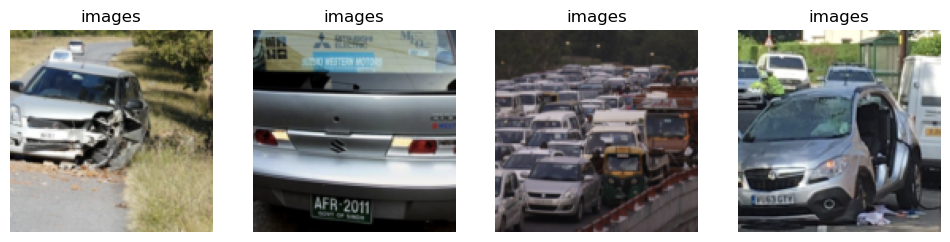

In [33]:
dls = plates.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=1)